# 1.Setup

### Dependencies

In [1]:
import cv2
import os 
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPool2D,Input,Flatten
import tensorflow as tf

### Set up GPU growth

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Creating Folders 

In [3]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Collecting Data

##### Collecting negative images

In [5]:
# Uncompressing the tar gz labelled faced from wild dataset  
!tar -xf lfw.tgz

In [6]:
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw', directory)
    if os.path.isdir(directory_path):
        for file in os.listdir(directory_path):
            EX_PATH=os.path.join(directory_path,file)
            NEW_Path=os.path.join(NEG_PATH,file)
            os.replace(EX_PATH,NEW_Path)

##### Collecting anchor and positive images

In [7]:
import uuid

In [8]:
cap=cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)

while cap.isOpened():
    
    ret,frame=cap.read()
    frame = cv2.resize(frame, (250, 250))
    frame=cv2.flip(frame,1)
    # collecting anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    # collecting positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    cv2.imshow('Image Collection',frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
frame.shape

(250, 250, 3)

### Loading and preprocessing images

In [12]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [13]:
dir_test=anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/77c801b0-9e8e-11ee-837f-c251d09dda8f.jpg'


In [14]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

In [15]:
img=preprocess('data/anchor/a1b509be-9e8e-11ee-837f-c251d09dda8f.jpg')

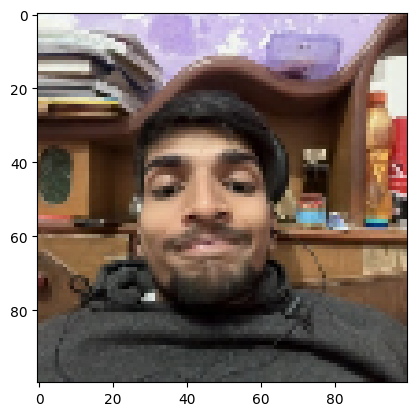

In [16]:
plt.imshow(img)

### Labeling the data

In [17]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [18]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [19]:
samples=data.as_numpy_iterator()

In [20]:
example=samples.next()

In [21]:
example

(b'data/anchor/69e229e0-9e8e-11ee-837f-c251d09dda8f.jpg',
 b'data/positive/ecd35e64-9e8e-11ee-837f-c251d09dda8f.jpg',
 1.0)

In [22]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [23]:
rs=preprocess_twin(*example)

In [24]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [25]:
samples=data.as_numpy_iterator()

In [26]:
samp=samples.next()

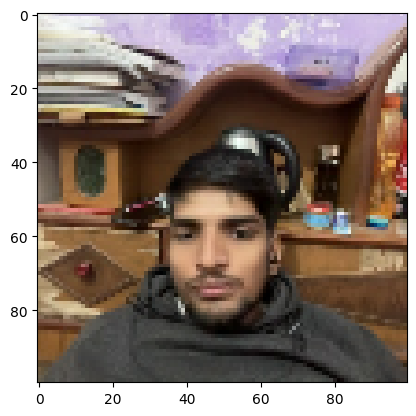

In [27]:
plt.imshow(samp[0])

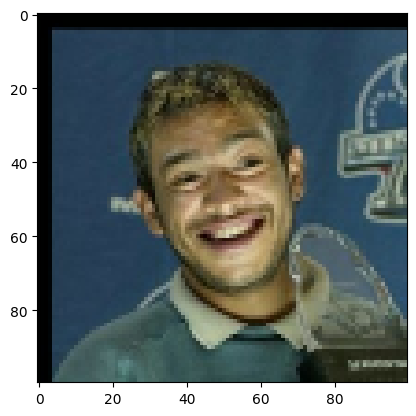

In [28]:
plt.imshow(samp[1])

In [29]:
samp[2]

0.0

### splitting the data

In [30]:
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [31]:
len(train_data)

27

In [32]:
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [33]:
len(test_data)

12

### Model Engineering

In [34]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_image')
    
    c1=Conv2D(filters=64,kernel_size=(10,10),activation='relu')(inp)
    m1=MaxPool2D(64,(2,2),padding='same')(c1)
    
    c2=Conv2D(filters=128,kernel_size=(7,7),activation='relu')(m1)
    m2=MaxPool2D(64,(2,2),padding='same')(c2)
    
    c3=Conv2D(filters=128,kernel_size=(4,4),activation='relu')(m2)
    m3=MaxPool2D(64,(2,2),padding='same')(c3)
    
    c4=Conv2D(filters=256,kernel_size=(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp],outputs=[d1],name="embedding")

In [35]:
model=make_embedding()

In [36]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [37]:
class L1Dist(Layer):
    
    def __init__(self,**kwargs):
        super().__init__()
        
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [38]:
l1=L1Dist()

In [125]:
l1

In [41]:
def make_siamese_model():
    
    input_image=Input(name='input_image',shape=(100,100,3)) #Anchor image
    validation_image=Input(name='validation_img',shape=(100,100,3))#Validation Image
    
    siamese_layer=L1Dist()
    siamese_layer._name="distance"
    distances=siamese_layer(model(input_image),model(validation_image))
    
    classifier=Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [42]:
siamese_model=make_siamese_model()

In [43]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_img[0][0]']      
                                                                                     

In [44]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [45]:
opt=tf.optimizers.legacy.Adam(learning_rate=1e-4)

In [46]:
checkpoint_dir= './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [47]:
test_batch=train_data.as_numpy_iterator()

In [48]:
batch_1=test_batch.next()

In [134]:
X=batch_1[:2]

In [135]:
X

(array([[[[0.94191176, 0.94191176, 0.89485294],
          [0.95098037, 0.95098037, 0.9117647 ],
          [0.94730395, 0.94730395, 0.9080882 ],
          ...,
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236]],
 
         [[0.9014706 , 0.86813724, 0.82009804],
          [0.8901961 , 0.85588235, 0.810049  ],
          [0.8784314 , 0.84117645, 0.80196077],
          ...,
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236]],
 
         [[0.31029412, 0.2365196 , 0.18848039],
          [0.30735293, 0.23357843, 0.1860294 ],
          [0.29460785, 0.21617647, 0.17671569],
          ...,
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236],
          [0.9254902 , 0.92941177, 0.90588236]],
 
         ...,
 
         [[0.00392157, 0.        , 0.        ],
          [0.02892

In [136]:
y=batch_1[2]

In [138]:
len(y)

16

In [50]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [51]:
y=batch_1[2]

In [52]:
y

array([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

### Training the network

In [53]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
       
        X=batch[:2]
        y=batch[2]
        
        yhat=siamese_model(X,training=True)
        
        loss=binary_cross_loss(y,yhat)
        print(loss)
       
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss    

In [54]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
        
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch%10 ==0 :
            checkpoint.save(file_prefix=checkpoint_prefix)

In [55]:
EPOCHS=50

In [68]:
train(train_data,EPOCHS)


 Epoch1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 54s 2s/step

 Epoch2/50
27/27 [==============================] - 47s 2s/step

 Epoch3/50
27/27 [==============================] - 47s 2s/step

 Epoch4/50
27/27 [==============================] - 47s 2s/step

 Epoch5/50
27/27 [==============================] - 47s 2s/step

 Epoch6/50
27/27 [==============================] - 47s 2s/step

 Epoch7/50
27/27 [==============================] - 47s 2s/step

 Epoch8/50
27/27 [==============================] - 47s 2s/step

 Epoch9/50
27/27 [==============================] - 47s 2s/step

 Epoch10/50
27/27 [==============================] - 47s 2s/step

 Epoch11/50
27/27 [==============================] - 47s 2s/step

 Epoch12/50
27/27 [==============================] - 47s 2s/step

 Epoch13/50
27/27 [==============================] - 47s 2s/st

In [69]:
from tensorflow.keras.metrics import Precision,Recall

In [70]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [142]:
y_hat=siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 205ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [2.2580130e-05],
       [9.9999893e-01],
       [1.2892158e-11],
       [1.0000000e+00],
       [9.9998987e-01],
       [1.6240159e-10],
       [3.4550126e-07],
       [1.0000000e+00],
       [3.3640781e-11],
       [8.5465114e-11],
       [1.6016024e-06],
       [1.0000000e+00],
       [6.8496064e-10],
       [4.7547459e-11]], dtype=float32)

In [72]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]

In [73]:
y_true

array([1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [74]:
r=Recall()
r.update_state(y_true,y_hat)
print(r.result().numpy())

p=Recall()
p.update_state(y_true,y_hat)
print(p.result().numpy())

1.0
1.0


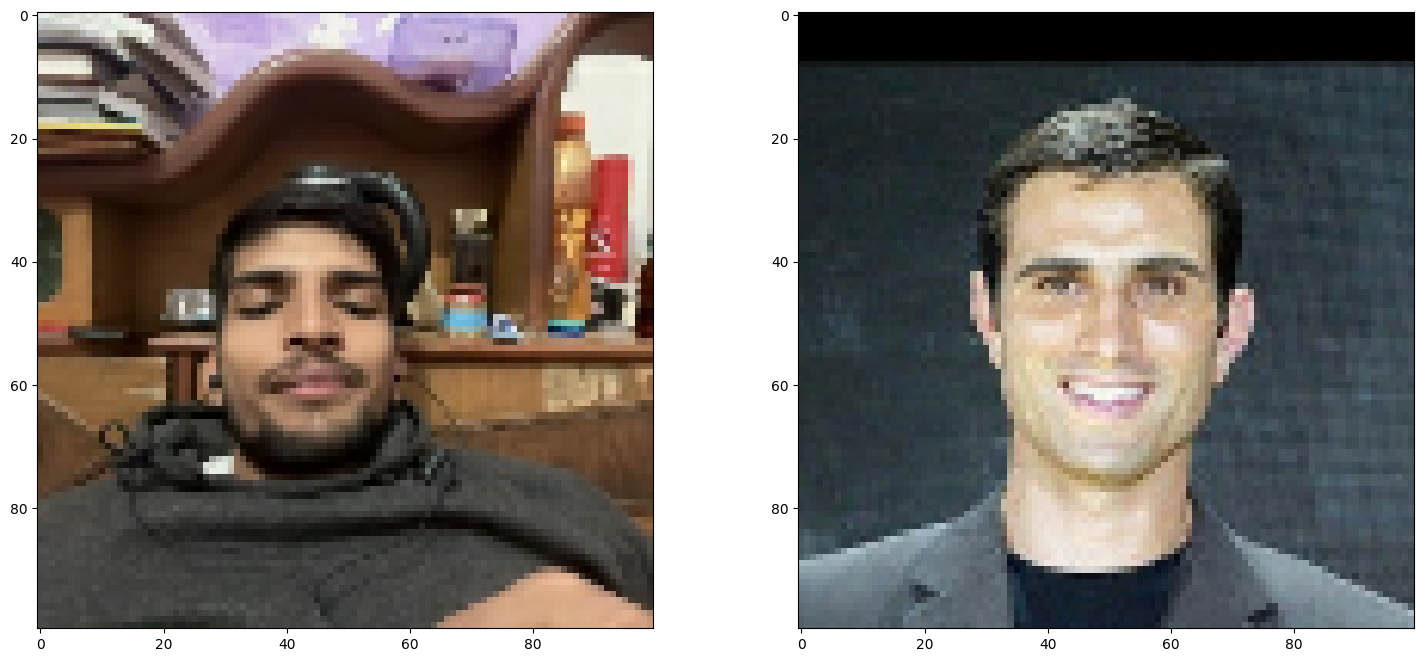

In [75]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.imshow(test_input[2])

plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

### Saving the model

In [76]:
siamese_model.save('siamesemodel.h5')

In [77]:
siamese_model.save('siamesemodel.keras')

In [78]:
model=tf.keras.models.load_model('siamesemodel.h5',
        custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [79]:
model.predict([test_input,test_val])

1/1 [==============================] - 1s 653ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [2.2580130e-05],
       [9.9999893e-01],
       [1.2892158e-11],
       [1.0000000e+00],
       [9.9998987e-01],
       [1.6240159e-10],
       [3.4550126e-07],
       [1.0000000e+00],
       [3.3640781e-11],
       [8.5465114e-11],
       [1.6016024e-06],
       [1.0000000e+00],
       [6.8496064e-10],
       [4.7547459e-11]], dtype=float32)

In [81]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_img[0][0]']      
                                                                                     

### Testing

### verification function

In [98]:
for image in os.listdir(os.path.join('application_data','verification_image')):
    print(os.path.join('application_data','verification_image',image))

application_data/verification_image/download (2) 5.04.54 PM.jpeg
application_data/verification_image/download (3).jpeg
application_data/verification_image/.DS_Store
application_data/verification_image/download (1).jpeg
application_data/verification_image/download (3) 5.04.54 PM.jpeg
application_data/verification_image/download (4).jpeg
application_data/verification_image/download (2).jpeg
application_data/verification_image/download (1) 5.04.54 PM.jpeg


In [88]:
def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_image')):
        
        input_img=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data','verification_image',image))
        
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
        
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/len(os.listdir(os.path.join('application_data','verification_image')))
    verified=verification>verification_threshold
    
    return results,verified

### OpenCV Real Time Verification

In [123]:
cap=cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)
while cap.isOpened():
    ret,frame=cap.read()
    frame = cv2.resize(frame, (250, 250))
    frame=cv2.flip(frame,1)
    
    cv2.imshow('verification',frame)
    
    if cv2.waitKey(1) & 0XFF==ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results,verified=verify(model,0.7,0.6)
        print(verified)
    
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 10ms/step
True
1/1 [==============================] - 0s 10ms/step
True


In [114]:
np.sum(np.squeeze(results)>0.7)

4

In [115]:
4/7

0.5714285714285714